In [2]:
import pandas as pd 
import wandb

api = wandb.Api()
entity, project = "jack-morris", "emb-inv-1"  # set to your entity and project 
# runs = api.runs(entity + "/" + project) 

exp_runs = [run for run in runs if run.config.get('exp_group_name') == 'mar17-baselines']

data = []
for run in exp_runs:
    summary = {k: v for k,v in run.summary.items() if not k.startswith('gradients/')}
    obj = {**run.config, **summary}
    data.append(obj)

df = pd.DataFrame(data)

In [3]:
df.head()

,bf16,fp16,fsdp,seed,tf32,debug,optim,_n_gpu,do_eval,no_cuda,...,val_text_preds,train/global_step,eval/accuracy,eval/samples_per_second,train/train_loss,train/train_runtime,_wandb,train/total_flos,train/train_steps_per_second,train/train_samples_per_second
0,True,False,,42,None,,adamw_hf,1,False,False,...,"{'nrows': 50, 'sha256': '9159e0a7b09f7adb1af35...",558400,0.439067,52.316,NaN,NaN,NaN,NaN,NaN,NaN
1,True,False,,42,None,,adamw_hf,1,False,False,...,"{'nrows': 50, 'sha256': 'f546f35268753fb4d3ea2...",999744,0.413656,123.865,3.476624,182259.7754,{'runtime': 182313},0.0,5.485,702.122
2,True,False,,42,None,,adamw_hf,1,False,False,...,"{'nrows': 50, 'sha256': 'a5356f6b49a1b7879bb4c...",999744,0.385091,166.576,4.051647,151500.6101,{'runtime': 151536},0.0,6.599,844.674
3,True,False,,42,None,,adamw_hf,1,False,False,...,"{'_type': 'table-file', 'ncols': 2, 'nrows': 5...",999744,0.976888,179.716,0.168228,163458.0810,{'runtime': 163540},0.0,6.116,782.883
4,True,False,,42,None,,adamw_hf,1,False,False,...,{'artifact_path': 'wandb-client-artifact://vek...,999744,1.000000,180.654,0.027809,200125.6296,{'runtime': 200212},0.0,4.996,639.441


In [4]:
df['embedder_fake_with_zeros'].value_counts()

False    6
True     3
Name: embedder_fake_with_zeros, dtype: int64

In [5]:
# make new value for this experiment
from typing import Dict
def embedder_exp_str(row: Dict) -> str:
    # weird - have to compare to True value or else nan will eval to True
    if row['embedder_fake_with_zeros'] == True:
        return 'Unconditional'
    elif row['embedder_no_grad']:
        return 'Reconstruct from embedding'
    else:
        return 'Input-conditioned (Autoencoder)'

df['embedder_exp'] = df.apply(embedder_exp_str, axis=1)

In [6]:
import math

df['eval/bits_per_token'] = df['eval/perplexity'].apply(math.log2)
df['eval/bits'] = df['eval/bits_per_token'] * (df['max_seq_length'] - 1)

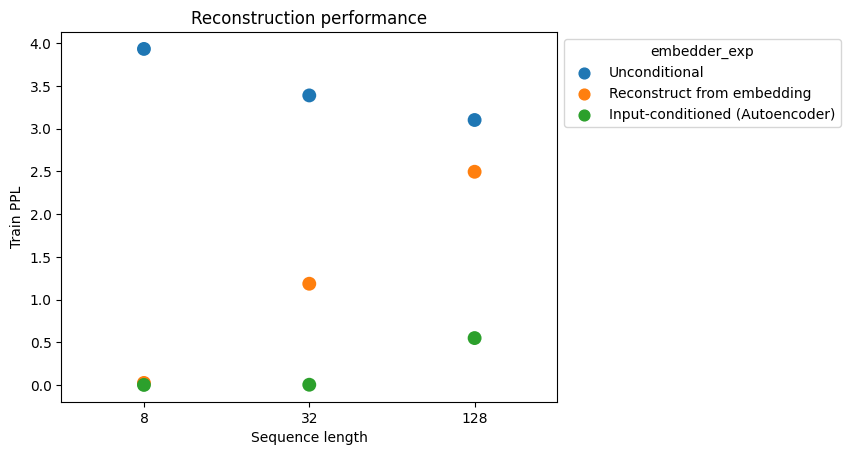

In [8]:
import seaborn as sns

ax = sns.stripplot(
    data=df, x='max_seq_length', y='train/loss', 
    hue='embedder_exp', jitter=False, size=10
)
ax.set_xlabel('Sequence length')
ax.set_ylabel('Train PPL')
# ax.set_yscale("log")
ax.set_title('Reconstruction performance')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

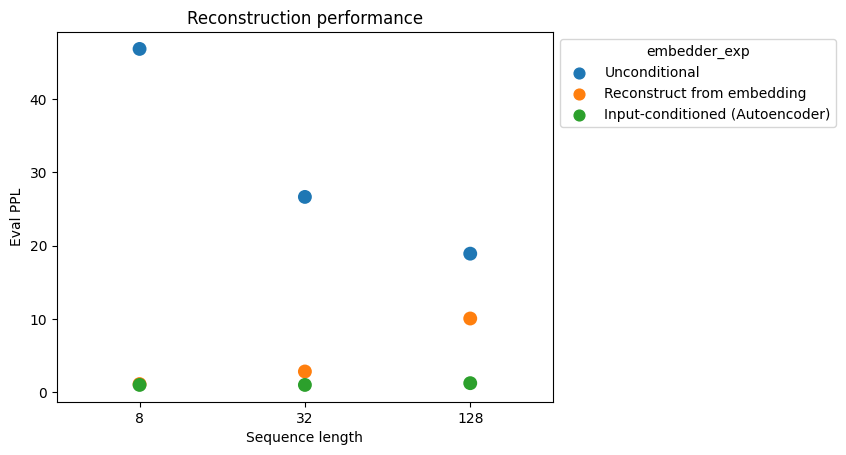

In [9]:
ax = sns.stripplot(
    data=df, x='max_seq_length', y='eval/perplexity', 
    hue='embedder_exp', jitter=False, size=10
)
ax.set_xlabel('Sequence length')
ax.set_ylabel('Eval PPL')
# ax.set_yscale("log")
ax.set_title('Reconstruction performance')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

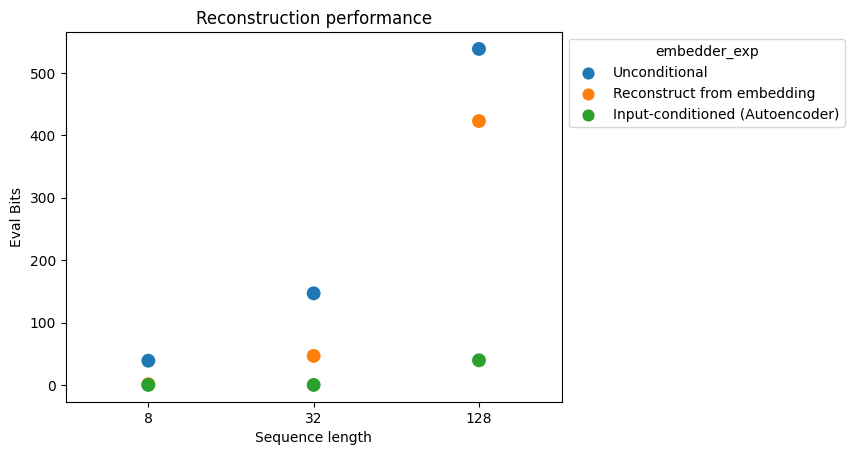

In [11]:
ax = sns.stripplot(
    data=df, x='max_seq_length', y='eval/bits', 
    hue='embedder_exp', jitter=False, size=10
)
ax.set_xlabel('Sequence length')
ax.set_ylabel('Eval Bits')
# ax.set_yscale("log")
ax.set_title('Reconstruction performance')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Text(0.5, 1.0, 'Reconstruction performance')

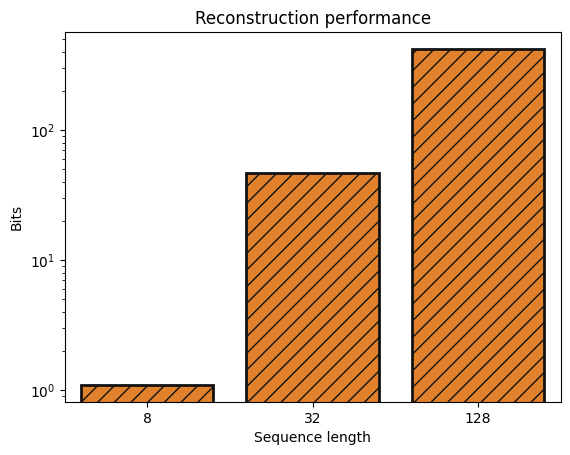

In [13]:
ax = sns.barplot(
    data=df[df['embedder_exp'] == 'Reconstruct from embedding'], 
    x='max_seq_length', y='eval/bits', 
    hatch="//",
    linewidth=2, edgecolor="#121212",
    color=sns.color_palette()[1],
    # linewidth=14,
)
ax.set_xlabel('Sequence length')
ax.set_ylabel('Bits')
ax.set_yscale("log")
ax.set_title('Reconstruction performance')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))?

Text(0.5, 1.0, 'Reconstruction performance')

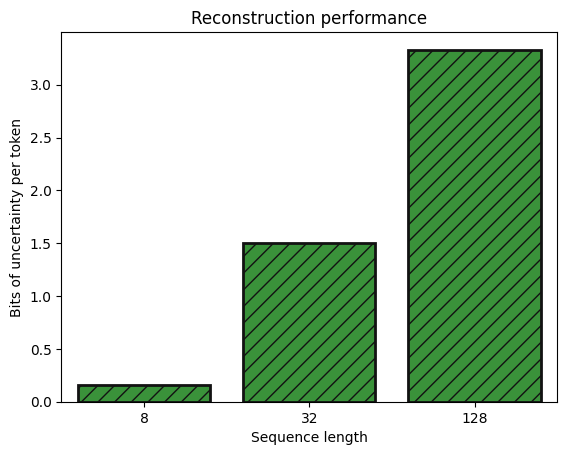

In [15]:
ax = sns.barplot(
    data=df[df['embedder_exp'] == 'Reconstruct from embedding'], 
    x='max_seq_length', y='eval/bits_per_token', 
    hatch="//",
    linewidth=2, edgecolor="#121212",
    color=sns.color_palette()[2],
    # linewidth=14,
)
# ax.set_ylim([0, 10])
ax.set_xlabel('Sequence length')
ax.set_ylabel('Bits of uncertainty per token')
# ax.set_yscale("log")
ax.set_title('Reconstruction performance')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))?

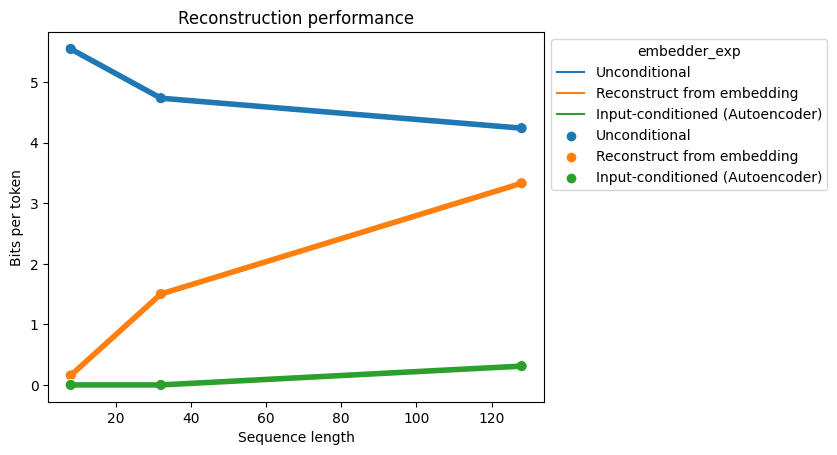

In [18]:
ax = sns.lineplot(
    data=df, x='max_seq_length', y='eval/bits_per_token', 
    hue='embedder_exp', lw=4,
)
ax = sns.scatterplot(
    data=df, x='max_seq_length', y='eval/bits_per_token', 
    hue='embedder_exp', s=64,
)
ax.set_xlabel('Sequence length')
ax.set_ylabel('Bits per token')
# ax.set_yscale("log")
ax.set_title('Reconstruction performance')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

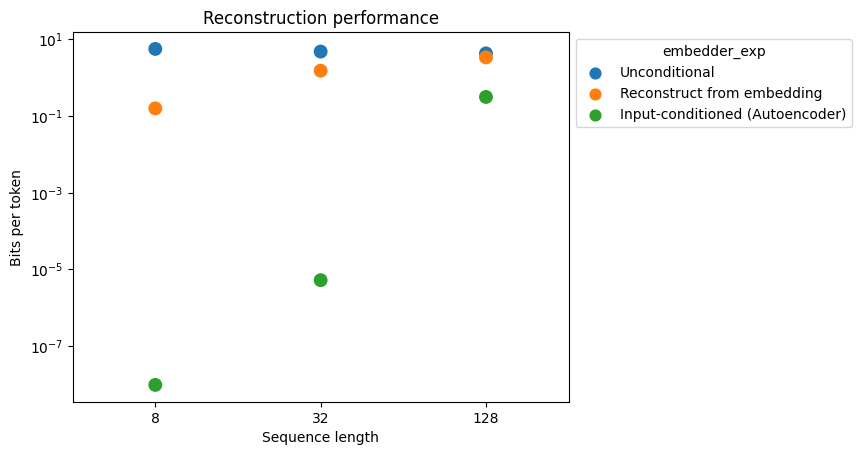

In [19]:
ax = sns.stripplot(
    data=df, x='max_seq_length', y='eval/bits_per_token', 
    hue='embedder_exp', jitter=False, size=10
)
ax.set_xlabel('Sequence length')
ax.set_ylabel('Bits per token')
ax.set_yscale("log")
ax.set_title('Reconstruction performance')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [20]:
df['embedder_exp'].value_counts()

Unconditional                      3
Reconstruct from embedding         3
Input-conditioned (Autoencoder)    3
Name: embedder_exp, dtype: int64

Text(0.5, 1.0, 'Bits extracted from embedding')

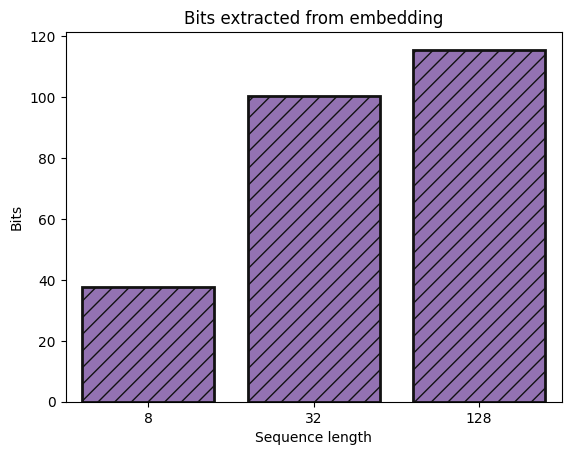

In [23]:
def bit_differential(df):
    unc = df[df['embedder_exp'] == 'Unconditional']
    assert len(unc) == 1
    unc = unc.iloc[0]
    #
    cond = df[df['embedder_exp'] == 'Reconstruct from embedding']
    assert len(cond) == 1
    cond = cond.iloc[0]
    #
    df['bit_differential'] = unc['eval/bits'] - cond['eval/bits']
    return df

bcdf = df.groupby('max_seq_length').apply(bit_differential)

# 
# 
# 

ax = sns.barplot(
    data=bcdf[bcdf['embedder_exp'] == 'Reconstruct from embedding'], 
    x='max_seq_length', y='bit_differential', 
    color=sns.color_palette()[4],
    hatch="//",
    linewidth=2, edgecolor="#121212",
)
ax.set_xlabel('Sequence length')
ax.set_ylabel('Bits')
# ax.set_yscale("log")
ax.set_title('Bits extracted from embedding')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))?
    

## gzip file sizes

In [32]:
import glob
glob.glob('../embeddings/nq_dev__gtr_base*char*gz')

['../embeddings/nq_dev__gtr_base__128_char.txt.gz',
 '../embeddings/nq_dev__gtr_base__32_char.txt.gz',
 '../embeddings/nq_dev__gtr_base__8_char.txt.gz']

In [31]:
import os
os.path.getsize('../embeddings/nq_dev__gtr_base__8_char.txt.gz') / 10_000 * 8

22796.468

In [29]:
768*32

24576

In [51]:
files_data = [
    (n, os.path.getsize(f'../embeddings/nq_dev__gtr_base__{n}_char.txt.gz')) for n in (8, 32, 128)
]
df_files = pd.DataFrame(files_data, columns=['max_seq_length', 'file_size'])
num_embeddings_in_file = 10_000
bits_per_byte = 8
df_files['bits_per_emb'] = df_files['file_size'] / num_embeddings_in_file * bits_per_byte
df_files['max_bits_per_emb'] = 768*32

In [52]:
bits_extracted = bcdf[bcdf['embedder_exp'] == 'Reconstruct from embedding'].sort_values(by='max_seq_length')['bit_differential']
df_files['bits_extracted'] = bits_extracted.tolist()

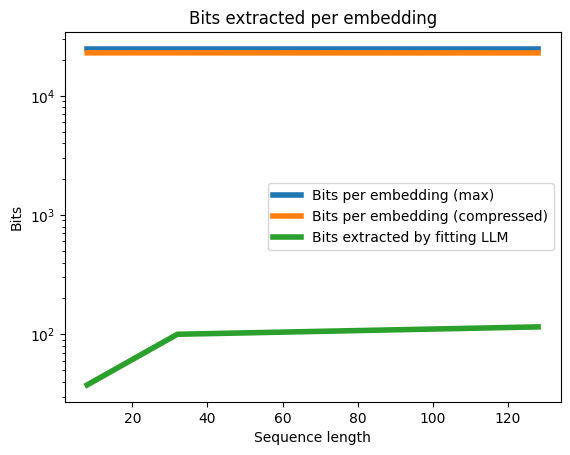

In [78]:
# sns.barplot(
#     data=df_files, 
#     x='max_seq_length', y=['bits_per_emb', 'bits_extracted'], 
#     color=sns.color_palette()[4],
#     hatch="//",
#     linewidth=2, edgecolor="#121212",
# )

new_labels = {'max_bits_per_emb': 'Bits per embedding (max)', 
                            'bits_per_emb': 'Bits per embedding (compressed)',
                            'bits_extracted': 'Bits extracted by fitting LLM'}
df_files = df_files.rename(columns=new_labels)
columns_to_plot = list(map(new_labels.get, ['max_bits_per_emb', 'bits_per_emb', 'bits_extracted']))
ax = df_files.plot(x='max_seq_length', y=columns_to_plot, kind='line', lw=4)
# ax = df_files.plot(x=['max_seq_length', 'max_seq_length', 'max_seq_length'], y=['max_bits_per_emb', 'bits_per_emb', 'bits_extracted'], kind='scatter', lw=4)

ax.set_title('Bits extracted per embedding')

ax.set_ylabel("Bits")
ax.set_xlabel("Sequence length")
ax.set_yscale("log")